In [2]:
import codecs
from subword_nmt.apply_bpe import BPE

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.data_repeat_to_instance import repeat_data
from utils.Model import Mut_DrugESPF_Model
from utils.split_data_id import split_id
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density
from utils.tools import get_data_value_range
from utils.plot import loss_curve

In [2]:
import os
print(os.getcwd())

/root/DeepTTA


pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
print(f"Training on device {device}.")

# information
filename     = "ESPF_Train_byCCL_drug_mut_AUC_1fold"
test_dataset = True # True:small dataset, False: full dataset
test_epochs = True

seed = 42
#hyperparameter
model_name = "Mut_DrugESPF_Model"
splitType= 'byDrug'
valueMultiply=1

mut_encode_dim =[1000,100,50] #6009genes
max_drug_len=50 # 補零補到50 / 取前50個subwords(index) !!!!須改方法!!!!
drug_embedding_feature_size = 128
drug_encode_dim =[1600,400,100] # 50*128
mut_encode_dim_save = f'(1000_100_50)'
drug_encode_dim_save= f'(1600_400_100)'
activation_func = nn.ReLU()  # ReLU activation function
activation_func_final = nn.Sigmoid()# sigmoid() or ReLU() # Linear(when -log2AUC)
dense_layer_dim = mut_encode_dim[2]+drug_encode_dim[2] # MLPDim
batch_size = 64
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 150
Decrease_percent = 0.99
continuous = True
learning_rate=1e-05
criterion = nn.MSELoss()

TCGA_pretrain_weight_path = "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt"
dropout_rate = 0

if test_epochs is True:
    num_epoch = 2
    print("num_epoch:",num_epoch)

hyperparameter_print = f' model_name ={model_name}\n splitType ={splitType}\n valueMultiply ={valueMultiply}\n mut_encode_dim ={mut_encode_dim}\n drug_encode_dim ={drug_encode_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n dense_layer_dim = {dense_layer_dim}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n dropout_rate ={dropout_rate}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n'
hyperparametersave = f'data*{valueMultiply}_{splitType}_Mut{mut_encode_dim_save}Drug{drug_encode_dim_save}ActF{activation_func}ActFFinl{activation_func_final}MLPDim{dense_layer_dim}BSZ{batch_size}Epoc{num_epoch}Patien{patience}warmup{warmup_iters}Decre%{Decrease_percent}LR{learning_rate}{criterion}DrugEmbSZ{drug_embedding_feature_size}DrpO{dropout_rate}'


Training on device cuda.
num_epoch: 2


In [4]:
#load data
# data_mut, gene_names_mut,ccl_names_mut  = load_ccl("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt")
ccl_mut_df= pd.read_csv("../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt", sep='\t', index_col=0)
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# data_AUC_matrix, drug_names_AUC, ccl_names_AUC = load_AUC_matrix(splitType,"/root/Winnie/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted.csv") # splitType = "byCCL" or "byDrug" 決定AUCmatrix要不要轉置
print("\n\nDatasets successfully loaded.")
print("drug_df",(np.shape(drug_df)))
print("ccl_mut_df",(np.shape(ccl_mut_df)))
print("AUC_df",np.shape(AUC_df))



Datasets successfully loaded.
drug_df (1440, 9)
ccl_mut_df (476, 6009)
AUC_df (480, 1440)


In [5]:
matched_samples = sorted(set(AUC_df.T.columns) & set(ccl_mut_df.T.columns))
print(len(matched_samples))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)

476
AUC_df (476, 1440)


In [6]:
if test_dataset is True:
    drug_df=drug_df[:42]
    ccl_mut_df=ccl_mut_df[:76]
    AUC_df=AUC_df.iloc[:76,:42]
print(drug_df.shape)
print(ccl_mut_df.shape)
print(AUC_df.shape)

(42, 9)
(76, 6009)
(76, 42)


In [7]:
drug_smiles =drug_df["smiles"]
print(drug_smiles.shape)
drug_names =drug_df.index
print((drug_smiles.unique()).shape)
# print(drug_names)

(42,)
(42,)


In [ ]:
# 檢查有無重複的SMILES
duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
print(duplicate)


Series([], Name: smiles, dtype: object)


In [ ]:
vocab_path = "./dataset/ESPF/drug_codes_chembl_freq_1500.txt" # token
sub_csv = pd.read_csv("./dataset/ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

# smile_encode = pd.Series(drug_smiles.unique()).apply(drug2emb_encoder) # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
smile_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
# uniq_smile_dict = dict(zip(drug_smiles.unique(),smile_encode))# zip drug_smiles和其subword vector編碼 成字典

In [11]:
print(type(smile_encode))
print(smile_encode.shape)
print(type(smile_encode.index))
print((smile_encode.index.values).shape)
print((ccl_mut_df.index.values).shape)

num_ccl = ccl_mut_df.shape[0]
num_drug = smile_encode.shape[0]
print(num_ccl,num_drug)

<class 'pandas.core.series.Series'>
(42,)
<class 'pandas.core.indexes.base.Index'>
(42,)
(76,)
76 42


In [12]:
# randomly split
# 90% for training(10% for validation) and 10% for testing
id_unrepeat_train, id_unrepeat_val, id_unrepeat_test, _, id_train, id_val, id_test= split_id(num_ccl=num_ccl,num_drug=num_drug,splitType=splitType,repeat=True,kFold=False)

id_unrepeat_train (35,)
id_unrepeat_val (3,)
id_unrepeat_test (4,)
id_unrepeat_train_val (38,)
id_train.shape (2660,)
id_val.shape (228,)
id_test.shape (304,)


In [13]:
# ccl_exp_df= pd.read_csv("/root/data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt", sep='\t', index_col=0)
# ccl_exp_df=ccl_exp_df[:76]
# exp_features_tensor = torch.tensor(ccl_exp_df.values, dtype=torch.float32)
# exp_features_tensor.shape


In [15]:
# Convert your data to tensors if they're in numpy
mut_features_tensor = torch.tensor(ccl_mut_df.values, dtype=torch.float32)
drug_features_tensor = torch.tensor(np.array(smile_encode.values.tolist()), dtype=torch.long)
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32)


In [16]:
torch.manual_seed(seed)
dataset = CellDrugDataset(mut_features_tensor, drug_features=drug_features_tensor, response_matrix=response_matrix_tensor, splitType=splitType)

train_dataset = Subset(dataset, id_train)
val_dataset = Subset(dataset, id_val)
test_dataset = Subset(dataset, id_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
class Mut_DrugESPF_Model(nn.Module):
    def __init__(self,mut_encode_dim,drug_encode_dim, activation_func,activation_func_final,dense_layer_dim, device, 
                 embedding_feature_size,dropout_rate, num_mut_features, num_drug_features, TCGA_pretrain_weight_path=None):
        super(Mut_DrugESPF_Model, self).__init__()

# Define subnetworks for mutations
        self.model_mut = nn.Sequential(
            nn.Linear(num_mut_features,mut_encode_dim[0]), # model_mut[0] : (Linear(in_features=2649, out_features=1000, bias=True)
            activation_func, #model_mut[1] : ReLU()
            nn.Linear(mut_encode_dim[0], mut_encode_dim[1]), # model_mut[2]
            activation_func,
            nn.Linear(mut_encode_dim[1], mut_encode_dim[2]),
            activation_func)

        if TCGA_pretrain_weight_path is not None:
            # Load the state_dict #TCGA AE Pretrained Weights
            state_dict = torch.load(TCGA_pretrain_weight_path, map_location=device)
            # match the layer name to load weight
            encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}
            # Load only the encoder part
            self.model_mut.load_state_dict(encoder_state_dict)
            # Check if the keys match
            model_keys = set(self.model_mut.state_dict().keys())
            loaded_keys = set(encoder_state_dict.keys())
            if model_keys == loaded_keys:
                print("State_dict loaded successfully.")
            else:
                print("State_dict does not match the model's architecture.")
                print("Model keys: ", model_keys)
                print("Loaded keys: ", loaded_keys)
            
# Define subnetwork for drug ESPF features
        self.emb_f = Embeddings(substructure_size = 2586,
                         embedding_feature_size = embedding_feature_size,
                         max_position_size = num_drug_features,
                         dropout_rate = dropout_rate)
        self.output = SelfOutput(embedding_feature_size, dropout_rate) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention

        self.model_drug = nn.Sequential(
            nn.Linear(num_drug_features * embedding_feature_size, drug_encode_dim[0]),
            activation_func,
            nn.Dropout(dropout_rate),
            nn.Linear(drug_encode_dim[0], drug_encode_dim[1]),
            activation_func,
            nn.Dropout(dropout_rate),
            nn.Linear(drug_encode_dim[1], drug_encode_dim[2]),
            activation_func)
        # Initialize both weights and biases with Kaiming uniform initialization
        for layer in self.model_drug:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
                if layer.bias is not None:
                    init.zeros_(layer.bias)



# Calculate final input dimension
        final_input_dim = mut_encode_dim[-1]+ drug_encode_dim[-1]            
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(final_input_dim, dense_layer_dim),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize both weights and biases with Kaiming uniform initialization
        for layer in self.model_final_add:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
                if layer.bias is not None:
                    init.zeros_(layer.bias)

        
    def forward(self, cell,drug,dropout_rate):
        mut_embed = self.model_mut(cell[0].to(device=device))
        mask = drug[:, 1, :].to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :].to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128)
        # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
        mask_weight = torch.tensor(mask, dtype=torch.float32).unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)
        mask_weight = nn.Softmax(dim=-1)(mask_weight)
        mask_weight = nn.Dropout(dropout_rate)(mask_weight)
        drug_emb_masked = torch.matmul(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])

        drug_emb_masked = drug_emb_masked.reshape(-1,drug_emb_masked.shape[1]*drug_emb_masked.shape[2]) # flatten to (bsz, 50*128)
        drug_emb_masked = self.model_drug(drug_emb_masked) 
        # Concatenate embeddings from all subnetworks
        combined_mut_drug_embed = torch.cat([mut_embed, drug_emb_masked], dim=1)#dim=1: turn into 1D
        output = self.model_final_add(combined_mut_drug_embed)
        return output

In [74]:
def warmup_lr_scheduler(optimizer, warmup_iters, Decrease_percent,continuous=True):
    def f(epoch):
        if epoch >= warmup_iters:
            if continuous is True:
                return Decrease_percent ** (epoch-warmup_iters+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def evaluation(model, activation_func_final,dropout_rate , epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, eval_loader, device, correlation='', kfoldCV = None):

    eval_outputs = [] # for correlation
    eval_targets = [] # for correlation
    model.eval()
    model.requires_grad = False
    total_eval_loss = 0.0
    batch_idx_without_nan_count=0 # if a batch has [] empty list than don't count
    with torch.no_grad():
        for batch_idx,inputs in enumerate(eval_loader):
            cell,drug, target = inputs[0],inputs[1], inputs[-1].to(device=device)
            outputs = model(cell, drug,dropout_rate) # drug.to(torch.float32)
            
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 去除nan的項
            target = target[mask]# Apply the mask to filter out NaN values from both tensors
            outputs = outputs[mask]
            if isinstance(activation_func_final, nn.Sigmoid): # if ReLU(), no need
                outputs = outputs*valueMultiply
            eval_outputs.append(outputs.detach().cpu().numpy().reshape(-1))
            eval_targets.append(target.detach().cpu().numpy().reshape(-1))

            if target.numel() != 0: # if a batch has [] empty list than don't pass the if condition
                batch_idx_without_nan_count+=1
                batch_val_loss = criterion(outputs.reshape(-1), target.to(torch.float32).reshape(-1))
                assert batch_val_loss.requires_grad ==False# check requires_grad off
                if isinstance(criterion, nn.MSELoss):
                    total_eval_loss += (batch_val_loss.cpu().detach().numpy())/ (valueMultiply**2)
                elif isinstance(criterion, nn.L1Loss):
                    total_eval_loss += (batch_val_loss.cpu().detach().numpy())/ (valueMultiply)
        if batch_idx_without_nan_count > 0:
            mean_batch_eval_loss = total_eval_loss/(batch_idx_without_nan_count) # batches' average loss as one epoch's loss
    # just for evaluation in train epoch loop , and plot the epochs loss, not for correlation
    if correlation=='plotLossCurve': 
        if kfoldCV is True: # for kfold testset evaluation to pick the best fold on 
            print(f'Evaluation Test Loss: {mean_batch_eval_loss:.8f}')
            return mean_batch_eval_loss
        else :
            print(f'Epoch [{epoch + 1}/{num_epoch}] - mean_batch Validation Loss: {mean_batch_eval_loss:.8f}')
            val_epoch_loss_list.append(mean_batch_eval_loss)
            return mean_batch_eval_loss, val_epoch_loss_list
    # for inference after train epoch loop, and store output for correlation
    elif correlation in ['train', 'val', 'test']:
        print(f'Evaluation {correlation} Loss: {mean_batch_eval_loss:.8f}')
        return mean_batch_eval_loss, eval_targets, eval_outputs
    else:
        print('error occur when correlation argument is not correct')
        return 'error occur when correlation argument is not correct'




def train(model, activation_func_final,dropout_rate, optimizer, batch_size, num_epoch,patience, warmup_iters, Decrease_percent, continuous, learning_rate, criterion, valueMultiply, train_loader, val_loader, device, seed=42, kfoldCV = None):
    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    if warmup_iters is not None:
        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, Decrease_percent,continuous)

    best_val_loss = float('inf')
    best_weight=None
    counter = 0
    train_epoch_loss_list = []#  for train every epoch loss plot
    val_epoch_loss_list=[]#  for validation every epoch loss plot
    torch.manual_seed(seed)
    for epoch in range(num_epoch):
        model.train()
        model.requires_grad = True
        total_train_loss = 0.0
        batch_idx_without_nan_count=0 # if a batch has [] empty list than don't count
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            cell,drug, target = inputs[0],inputs[1], inputs[-1].to(device=device)
            outputs = model(cell, drug, dropout_rate) #drug.to(torch.float32)
            
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 去除nan的項
            target = target[mask]# Apply the mask to filter out NaN values from both tensors
            outputs = outputs[mask]
            
            if isinstance(activation_func_final, nn.Sigmoid): # ReLU就不用， Sigmoid要因為只有0~1
                outputs = outputs*valueMultiply
                
            if target.numel() != 0: # 確保batch中traget去除掉nan後還有數值 (count)
                batch_idx_without_nan_count+=1# if 這個batch有數值batch才累加 
                loss = criterion(outputs.reshape(-1), target.to(torch.float32).reshape(-1)) # 
                loss.backward()#計算 grad (partial Loss/partial weight)
                optimizer.step()# W'= W - (lr*delta W)
                if isinstance(criterion, nn.MSELoss):
                    total_train_loss += (loss.cpu().detach().numpy())/ (valueMultiply**2)
                elif isinstance(criterion, nn.L1Loss):
                    total_train_loss += (loss.cpu().detach().numpy())/ (valueMultiply)
            
        mean_batch_train_loss = total_train_loss/(batch_idx_without_nan_count)
        train_epoch_loss_list.append(mean_batch_train_loss) # mean_batch_train_loss = epoch_train_loss
        print(f'Epoch [{epoch + 1}/{num_epoch}] - mean_batch Training Loss: {mean_batch_train_loss:.8f}')  
        
        mean_batch_val_loss, val_epoch_loss_list = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, val_loader, device, correlation='plotLossCurve',kfoldCV = None)

        if warmup_iters is not None:
            print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()

        if mean_batch_val_loss < best_val_loss: # bestepoch
            best_val_loss = mean_batch_val_loss # bestepoch
            best_weight = copy.deepcopy(model.state_dict()) # bestepoch_weight
            best_epoch = epoch+1 # bestepoch
            counter = 0
            if kfoldCV is True:
                best_val_loss_mean_batch_train_loss = mean_batch_train_loss
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
    if kfoldCV is not True:
        best_val_loss_mean_batch_train_loss = None
    return best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list, best_val_loss_mean_batch_train_loss

In [75]:
%%time

# train
# Init the neural network 
torch.manual_seed(seed)
np.random.seed(seed)

model = Mut_DrugESPF_Model(mut_encode_dim, drug_encode_dim, activation_func, activation_func_final, dense_layer_dim, device,
                        drug_embedding_feature_size,dropout_rate, num_mut_features=ccl_mut_df.shape[1], num_drug_features=drug_features_tensor.shape[2],
                        TCGA_pretrain_weight_path= TCGA_pretrain_weight_path).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer

best_epoch, best_weight, best_val_loss, train_epoch_loss_list, val_epoch_loss_list,_ = train( model, activation_func_final,dropout_rate,
    optimizer,      batch_size,      num_epoch,      patience,      warmup_iters,      Decrease_percent,    continuous,
    learning_rate,      criterion,      valueMultiply,      train_loader,      val_loader,
    device,      seed=42, kfoldCV = None)

print("best Epoch : ",best_epoch,"best_val_loss : ",best_val_loss," batch_size : ",batch_size,
        "learning_rate : ",learning_rate," warmup_iters :" ,warmup_iters  ," with Decrease_percent : ",Decrease_percent )

# Saving the model weughts
save_path = f'./results/{filename}_BestValLoss{best_val_loss:.7f}_{hyperparametersave}.pt' # /root/Winnie/PDAC
torch.save(best_weight, save_path)


State_dict loaded successfully.


/tmp/ipykernel_3252/1109902386.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_weight = torch.tensor(mask, dtype=torch.float32).unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)


Epoch [1/2] - mean_batch Training Loss: 0.02226659
Epoch [1/2] - mean_batch Validation Loss: 0.00540339
lr of epoch 1 => [1e-05]
Epoch [2/2] - mean_batch Training Loss: 0.00808325
Epoch [2/2] - mean_batch Validation Loss: 0.00651207
lr of epoch 2 => [1e-05]
best Epoch :  1 best_val_loss :  0.005403387185651809  batch_size :  64 learning_rate :  1e-05  warmup_iters : 150  with Decrease_percent :  0.99
CPU times: user 1.88 s, sys: 133 ms, total: 2.01 s
Wall time: 4.54 s


<Figure size 800x600 with 0 Axes>

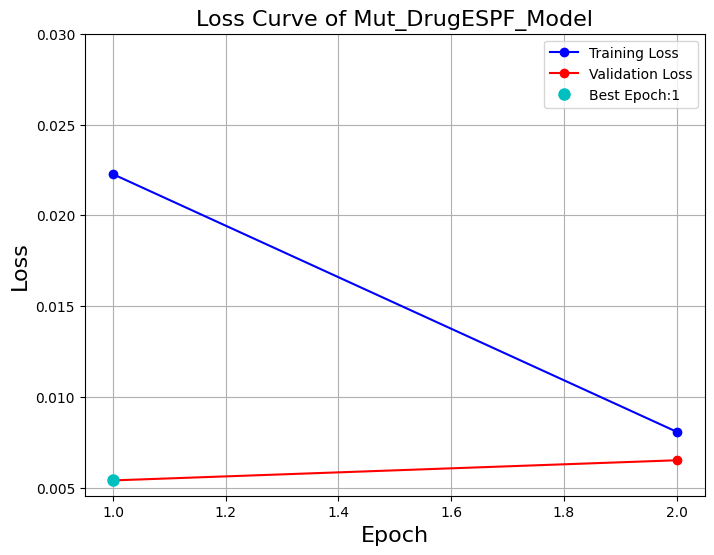

In [76]:
loss_curve(model_name, train_epoch_loss_list, val_epoch_loss_list, best_epoch, best_val_loss, ylim_top=0.03)

In [77]:
# Evaluation
#Evaluation on best fold best split id (train, val) with best_fold_best_weight 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Evaluation on the train set
model.load_state_dict(best_weight)  
model = model.to(device=device)
epoch = None
train_loss, train_targets, train_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, train_loader, device, correlation='train', kfoldCV = None)
# Evaluation on the validation set
model.load_state_dict(best_weight)  
model = model.to(device=device)
val_loss, val_targets, val_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, val_loader, device, correlation='val', kfoldCV = None)
# Evaluation on the test set
model.load_state_dict(best_weight)
model = model.to(device=device)
test_loss, test_targets, test_outputs = evaluation(model, activation_func_final,dropout_rate, epoch, num_epoch, val_epoch_loss_list, criterion, valueMultiply, test_loader, device, correlation='test', kfoldCV = None)



/tmp/ipykernel_3252/1109902386.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_weight = torch.tensor(mask, dtype=torch.float32).unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)


Evaluation train Loss: 0.01140910
Evaluation val Loss: 0.00540339
Evaluation test Loss: 0.00899616


transpose data_AUC_matrix((1440, 476)) to match split byDrug
len:  109
8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6) : 0.2659765195965878
len:  46
PREDNISOLONE-ACETATE (BRD:BRD-A01643550-001-04-9) : 0.4294272565671123
len:  166
BETAMETHASONE (BRD:BRD-A02180903-001-04-5) : 0.25035299548366324
len:  449
XL888 (BRD:BRD-A03506276-001-01-5) : 0.4295446683436234
len:  242
METHSCOPOLAMINE (BRD:BRD-A03932035-004-04-3) : 0.21808019206287788
len:  453
LAPPACONITE (BRD:BRD-A05906449-004-01-1) : 0.3401765325968458
len:  339
TERFENADINE (BRD:BRD-A06352418-001-25-9) : 0.12662788656167873
len:  368
SB-218078 (BRD:BRD-A06352508-001-03-7) : 0.3907704761751404
len:  417
DICLAZURIL (BRD:BRD-A06426627-001-03-5) : 0.30525918359053733
len:  405
MONENSIN (BRD:BRD-A06627858-236-03-0) : 0.3934448653329352
len:  427
GALETERONE (BRD:BRD-A07986123-001-02-8) : 0.34489785917683874
len:  465
CID-5458317 (BRD:BRD-A08840375-001-01-3) : 0.38588657437972745
len:  51
NORETHINDRONE-ACETATE (BRD:BRD-A09349126-001-10-7) : 0.019

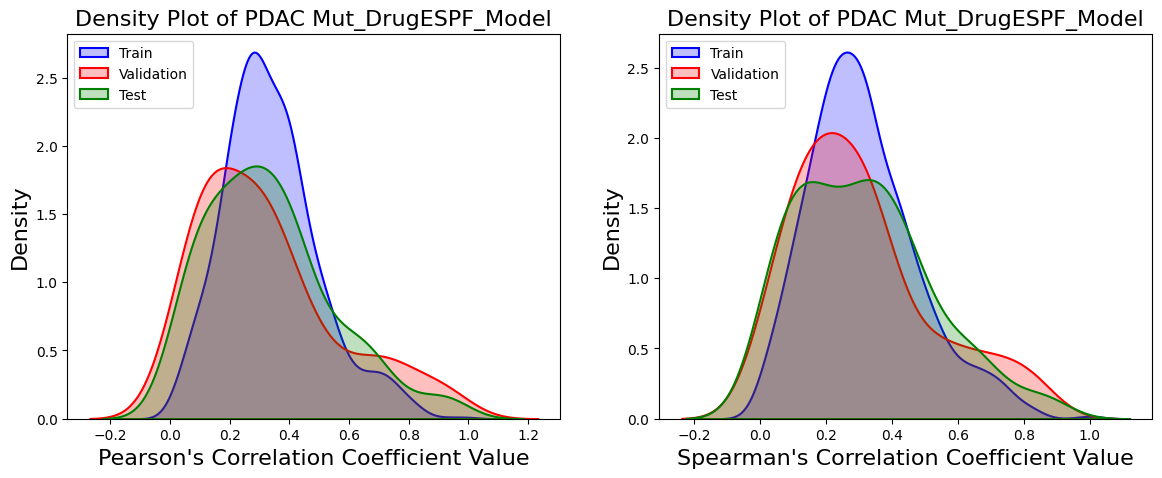

[0.9015548229217529, 0.8597138524055481, 0.940750777721405, 0.9198676347732544, 0.9370887875556946, 0.890850305557251, 0.8725842833518982, 0.8957944512367249, 0.8926684260368347, 0.9122161865234375]
(388051,)
(388051,)
[0.9999970197677612, 0.822102963924408, 0.9520841836929321, 0.9003132581710815, 0.9864409565925598, 0.920955240726471, 0.8985281586647034, 0.9906508922576904, 0.9575983881950378, 0.9167788028717041]


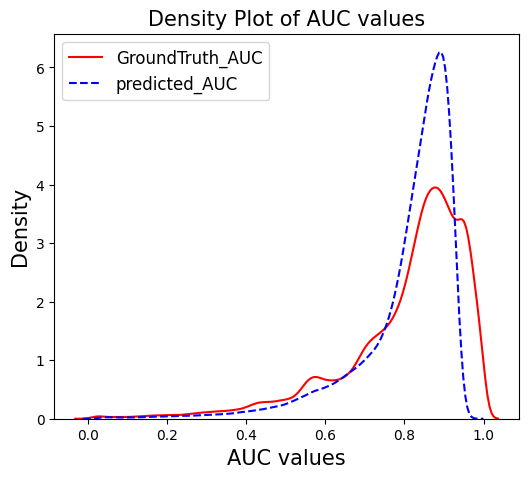

In [24]:
# Correlation
train_pearson, train_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_train,train_targets,train_outputs)
print("\n")
print("val set"+"="*20)
print("val set"+"="*20)
val_pearson, val_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_val,val_targets,val_outputs)
print("\n")
print("test set"+"="*20)
print("test set"+"="*20)
test_pearson, test_spearman = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)

#plot correlation_density
correlation_density(model_name,train_pearson,val_pearson,test_pearson,train_spearman,val_spearman,test_spearman)

# plot GroundTruth AUC and predicted AUC distribution
import seaborn as sns
import matplotlib.pyplot as plt
predicted_AUC = train_outputs + val_outputs + test_outputs
predicted_AUC = np.concatenate(predicted_AUC).tolist()
print(predicted_AUC[:10])
print(np.array(predicted_AUC).shape)
GroundTruth_AUC = train_targets + val_targets + test_targets
GroundTruth_AUC = np.concatenate(GroundTruth_AUC).tolist()
print(np.array(GroundTruth_AUC).shape)
print(GroundTruth_AUC[:10])

fig=plt.figure(figsize=(6, 5))
sns.kdeplot(GroundTruth_AUC, color='red', label='GroundTruth_AUC')
sns.kdeplot(predicted_AUC, color='blue', linestyle='dashed', label='predicted_AUC')
# Set the x-axis label to 'Density'
plt.xlabel('AUC values',fontsize=15)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density',fontsize=15)
# Set the title of the plot
plt.title('Density Plot of AUC values',fontsize=15)
plt.legend(fontsize=12)
plt.show()
fig.savefig('Density Plot of AUC values')

In [25]:
 # data range
get_data_value_range(GroundTruth_AUC,"GroundTruth_AUC")
get_data_value_range(predicted_AUC,"predicted_AUC")

# print hyperparameter and result
print(filename)
print(hyperparameter_print)
print('best epoch: ',best_epoch)

print(f'Evaluation Training Loss: {train_loss:.6f}')
print(f'Evaluation validation Loss: {val_loss:.6f}')
print(f'Evaluation Test Loss: {test_loss:.6f}')

print(f"Mean train_pearson PDAC {model_name}: ",np.mean(train_pearson))
print(f"Median train_pearson PDAC {model_name}: ",np.median(train_pearson))
print(f"Mode train_pearson PDAC {model_name}: ",stats.mode(np.round(train_pearson,2))[0],",count=",stats.mode(np.round(train_pearson,2))[1])

print(f"Mean val_pearson PDAC {model_name}: ",np.mean(val_pearson))
print(f"Median val_pearson PDAC {model_name}: ",np.median(val_pearson))
print(f"Mode val_pearson PDAC {model_name}: ",stats.mode(np.round(val_pearson,2))[0],",count=",stats.mode(np.round(val_pearson,2))[1])

print(f"Mean test_pearson PDAC {model_name}: ",np.mean(test_pearson))
print(f"Median test_pearson PDAC {model_name}: ",np.median(test_pearson))
print(f"Mode test_pearson PDAC {model_name}: ",stats.mode(np.round(test_pearson,2))[0],",count=",stats.mode(np.round(test_pearson,2))[1])

print(f"Mean train_spearman PDAC {model_name}: ",np.mean(train_spearman))
print(f"Median train_spearman PDAC {model_name}: ",np.median(train_spearman))
print(f"Mode train_spearman PDAC {model_name}: ",stats.mode(np.round(train_spearman,2))[0],",count=",stats.mode(np.round(train_spearman,2))[1])

print(f"Mean val_spearman PDAC {model_name}: ",np.mean(val_spearman))
print(f"Median val_spearman PDAC {model_name}: ",np.median(val_spearman))
print(f"Mode val_spearman PDAC {model_name}: ",stats.mode(np.round(val_spearman,2))[0],",count=",stats.mode(np.round(val_spearman,2))[1])

print(f"Mean test_spearman PDAC {model_name}: ",np.mean(test_spearman))
print(f"Median test_spearman PDAC {model_name}: ",np.median(test_spearman))
print(f"Mode test_spearman PDAC {model_name}: ",stats.mode(np.round(test_spearman,2))[0],",count=",stats.mode(np.round(test_spearman,2))[1])

print(f"Mean Median Mode train_pearson PDAC {model_name}: ",np.mean(train_pearson)," ",np.median(train_pearson)," ",stats.mode(np.round(train_pearson,2)))
print(f"Mean Median Mode val_pearson PDAC {model_name}: ",np.mean(val_pearson)," ",np.median(val_pearson)," ",stats.mode(np.round(val_pearson,2)))
print(f"Mean Median Mode test_pearson PDAC {model_name}: ",np.mean(test_pearson)," ",np.median(test_pearson)," ",stats.mode(np.round(test_pearson,2)))
print(f"Mean Median Mode train_spearman PDAC {model_name}: ",np.mean(train_spearman)," ",np.median(train_spearman)," ",stats.mode(np.round(train_spearman,2)))
print(f"Mean Median Mode val_spearman PDAC {model_name}: ",np.mean(val_spearman)," ",np.median(val_spearman)," ",stats.mode(np.round(val_spearman,2)))
print(f"Mean Median Mode test_spearman PDAC {model_name}: ",np.mean(test_spearman)," ",np.median(test_spearman)," ",stats.mode(np.round(test_spearman,2)))


GroundTruth_AUC  : 
Range: 0.99582593
Minimum: 0.00417407
Maximum: 1.00000000
Mean: 0.80428598
Median: 0.84954268
Standard Deviation: 0.16005997
binary data: False
-------------------------------------
predicted_AUC  : 
Range: 0.95414399
Minimum: 0.01617910
Maximum: 0.97032309
Mean: 0.80634519
Median: 0.84605855
Standard Deviation: 0.12822333
binary data: False
-------------------------------------
ESPF_Train_byCCL_drug_mut_AUC_1fold
 model_name =Mut_DrugESPF_Model
 splitType =byDrug
 valueMultiply =1
 mut_encode_dim =[1000, 100, 50]
 drug_encode_dim =[1600, 400, 100]
 activation_func = ReLU()
 activation_func_final = Sigmoid()
 dense_layer_dim = 150
 batch_size = 64
 num_epoch = 200
 patience = 20
 warmup_iters = 150
 Decrease_percent = 0.99
 continuous =True
 learning_rate = 1e-05
 criterion =MSELoss()
 dropout_rate =0
 drug_embedding_feature_size =128

best epoch:  15
Evaluation Training Loss: 0.005215
Evaluation validation Loss: 0.024650
Evaluation Test Loss: 0.021132
Mean train_pe